본 예제는 케라스 공식 홈페이지에 등록된 아래 예제를 바탕으로 만들어졌습니다. 

https://keras.io/examples/structured_data/collaborative_filtering_movielens/

**Author:** [Siddhartha Banerjee](https://twitter.com/sidd2006)<br>
**Date created:** 2020/05/24<br>
**Last modified:** 2020/05/24<br>
**Description:** Recommending movies using a model trained on Movielens dataset.

## 소개

이 예제는 협업필터링을 시연합니다.

https://en.wikipedia.org/wiki/Collaborative_filtering

사용자에게 영화를 추천하는 모델을 만들기 위해 Movielens 데이터셋을 사용합니다.

https://www.kaggle.com/c/movielens-100k

MovieLens 평점 데이터셋은 영화셋에 대한 사용자가 준 평점이 나열되어 있습니다. 목표는 사용자가 아직 보지 못한 영화의 평점을 추측하는 것입니다. 가장 높은 평점이 예측된다면 이를 사용자에게 추천하는 방식입니다.

모델 시나리오는 다음과 타습니다.

1. 사용자 아이디를 임베딩 매트릭스를 통해 사용자 벡터로 매핑합니다.
2. 영화 아이디를 임베딩 매트릭스를 통해 영화 벡터로 매핑합니다. 
3. 사용자와 영화 사이의 매칭 스코어(예측 평점)를 획득하기 위해  사용자 벡터와 영화 벡터의 내적을 계산합니다. 
4. 경사하강법을 통해 알려진 사용자와 영화 쌍으로 임베딩들을 학습시킵니다.

**References:**

- [Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/371920.372071)
- [Neural Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/3038912.3052569)


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from zipfile import ZipFile

## 먼저 데이터를 로딩하고 전처리를 수행합니다.

사용자와 영화 정보를 정수 인덱스로 인코딩합니다.


In [ ]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

991232/978202 [==============================] - 0s 0us/step
Extracting all the files now...
Done!


In [ ]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


## 훈련셋과 검증셋을 준비합니다.


In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

## 모델 생성

사용자와 영화를 50 차원의 벡터로 임베딩합니다.

모델은 내적을 통해 사용자와 영화 사이의 매칭 스코어를 계산합니다. 그리고 영화 마다 그리고 사용자 마다 바이어스도 추가합니다.

매칭 스코어는 시그모이드를 통해 `[0, 1]` 사이로 스케일 시킵니다. 평점 데이터도 사전에 이 범위로 정규화를 시킬 겁니다.

In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## 모델을 학습시키기


In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 10s 6ms/step - loss: 0.6364 - val_loss: 0.6203
Epoch 2/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6135 - val_loss: 0.6180
Epoch 3/5
1418/1418 [==============================] - 8s 5ms/step - loss: 0.6084 - val_loss: 0.6138
Epoch 4/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6075 - val_loss: 0.6120
Epoch 5/5
1418/1418 [==============================] - 8s 6ms/step - loss: 0.6069 - val_loss: 0.6127


## 학습 및 검증 손실 가시화


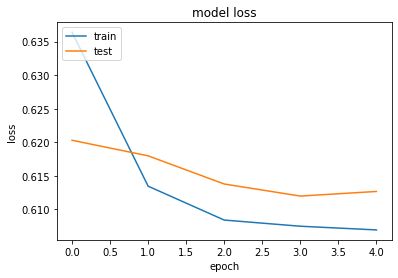

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

특정 사용자에게 10개의 영화 추천해보기

In [ ]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 608
Movies with high ratings from user
--------------------------------
Matrix Revolutions, The (2003) : Action|Adventure|Sci-Fi|Thriller|IMAX
Punisher, The (2004) : Action|Crime|Thriller
Shaun of the Dead (2004) : Comedy|Horror
300 (2007) : Action|Fantasy|War|IMAX
Transformers (2007) : Action|Sci-Fi|Thriller|IMAX
--------------------------------
Top 10 movie recommendations
--------------------------------
Rear Window (1954) : Mystery|Thriller
12 Angry Men (1957) : Drama
Lawrence of Arabia (1962) : Adventure|Drama|War
Amadeus (1984) : Drama
Boot, Das (Boat, The) (1981) : Action|Drama|War
Glory (1989) : Drama|War
Graduate, The (1967) : Comedy|Drama|Romance
Chinatown (1974) : Crime|Film-Noir|Mystery|Thriller
Stand by Me (1986) : Adventure|Drama
Cool Hand Luke (1967) : Drama
